In [1]:
# 필요한 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')



In [2]:
# 시계열 데이터 가져오기
data_path = os.getenv("HOME") + '/aiffel/stock_prediction/data/SONY.csv'

# 원본 데이터 확인하기
df = pd.read_csv(data_path)
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-17,115.309998,115.309998,113.860001,114.919998,114.919998,592200
1,2021-02-18,113.250000,113.870003,112.430000,113.519997,113.519997,567200
2,2021-02-19,114.010002,117.809998,113.910004,115.540001,115.540001,1988600
3,2021-02-22,113.529999,114.910004,113.029999,113.279999,113.279999,1096400
4,2021-02-23,110.970001,112.860001,109.540001,112.430000,112.430000,1067300


In [3]:
# 위 원본에서 종가만 사용한다
# Date 컬럼을 index로 삼아 시계열을 생성한다
df = pd.read_csv(data_path, index_col="Date", parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    114.919998
2021-02-18    113.519997
2021-02-19    115.540001
2021-02-22    113.279999
2021-02-23    112.430000
Name: Close, dtype: float64

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time') # 기준은 time으로 
ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()   # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차 plot으로 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)


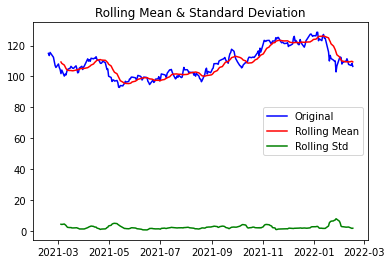

In [6]:
plot_rolling_statistics(ts)

차트가 우상향으로 아주 좋은 모습을 보이고 있다. (떡상 가즈아~)   
하지만 시간의 변화에 따라 평균과 분산이 증가해 시계열이 안정적이지 않다고 할 수 있기 때문에 **로그변환**을 해주도록한다

In [7]:
# 로그 변환
ts_log = np.log(ts)

In [8]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드 호출
    dftest = adfuller(timeseries, autolag="AIC")
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print("Results of Dickey-Fuller Test:")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

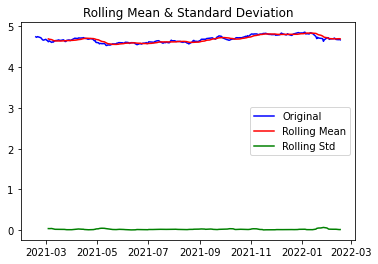

Results of Dickey-Fuller Test:
Test Statistic                  -1.755817
p-value                          0.402608
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


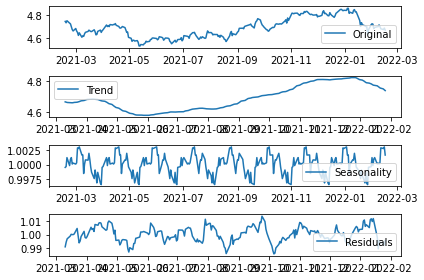

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

`Residual` = `Original` 데이터에서 `Trend`, `Seasonality` 제거하고 난 나머지

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True) # 결측치 제거
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.845772
p-value                          0.000044
#Lags Used                       1.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


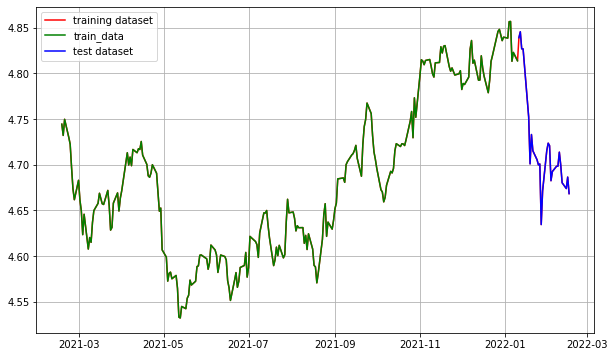

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(train_data, c='g', label='train_data')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

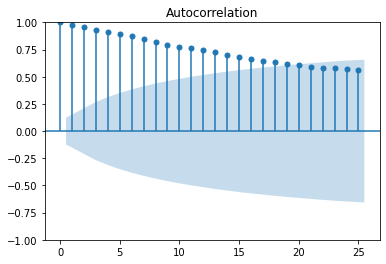

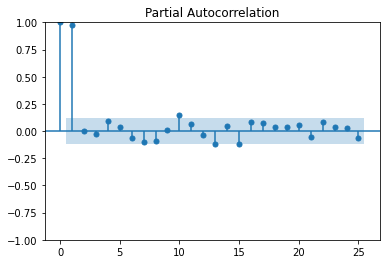

In [12]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.573053e+01
p-value                        1.291056e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


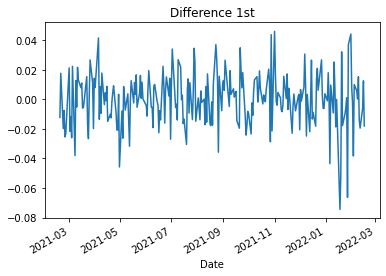

In [13]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [14]:
# # 필요할 때 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

In [15]:
# 모델 빌드하기
model = ARIMA(train_data, order=(14, 0, 1)) # order=c(p,d,q) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                ARIMA(14, 0, 1)   Log Likelihood                 622.049
Date:                Thu, 17 Feb 2022   AIC                          -1210.097
Time:                        14:22:35   BIC                          -1151.799
Sample:                             0   HQIC                         -1186.576
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7112      0.062     76.533      0.000       4.591       4.832
ar.L1          0.7758      2.917      0.266      0.790      -4.942       6.494
ar.L2          0.2818      2.872      0.098      0.9

In [16]:
# # 모델 훈련 결과 시각적으로 확인

# fitted_m = fitted_m.predict()
# fitted_m = fitted_m.drop(fitted_m.index[0])
# plt.figure(figsize=(20, 5))
# plt.plot(fitted_m, label='predict')
# plt.plot(train_data, label='train_data')
# plt.legend()

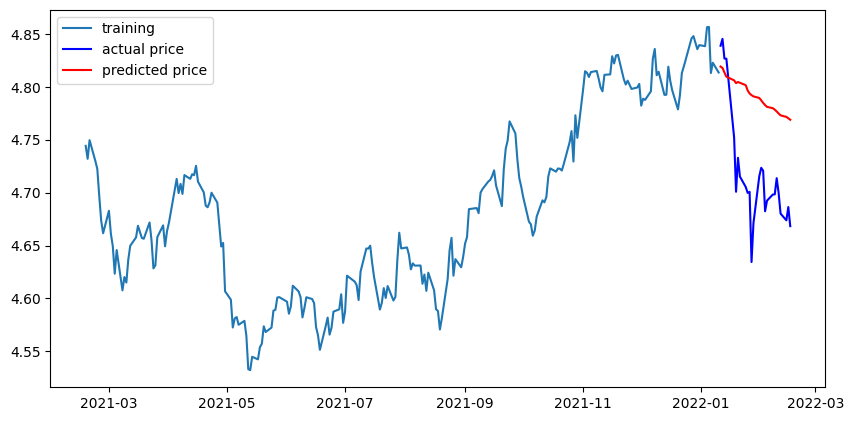

In [17]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [18]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  92.54597109133464
MAE:  8.942705220197954
RMSE:  9.62008165720721
MAPE: 8.14%
